In [1]:
#!git clone https://github.com/ZoneTsuyoshi/lock.git

In [2]:
import math
import os
import sys
import matplotlib.pyplot as plt
from scipy import integrate

import numpy as np


sys.path.append("./lock/src")
# from lock import LOCK
# from emkf import ExpectationMaximizationKalmanFilter
# from model import DampedOscillationModel
from scheme import EulerScheme

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
from model import ODE

In [4]:
save_dir = "./results/custom_exp_nonlin"

# make directory
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

perf_initial = np.array([1., -2.])
dt = 0.2
obs_sd = 0.2
sys_sd = 0.1
T = 200
update_interval = 4
seed = 121
np.random.seed(seed)
Q = np.array([[sys_sd**2, 0], [0, sys_sd**2]])
R = np.array([[obs_sd**2, 0], [0, obs_sd**2]])

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class TwoSpiral(ODE):
    
    def __init__(self, *args, **kwargs):
        self.x0 = np.array([-1., 2.])
        
        self.A1 = np.array([[-0.1, -0.5],
                           [0.5, -0.1]])
    
        self.A2 = np.array([[0.2, 1.],
                           [-1., 0.2]])
        super().__init__(*args, **kwargs)
    
    def f(self, x, t):
        alpha = sigmoid(np.sum(x*self.x0))
        return alpha*(x-self.x0)@self.A1 + (1.-alpha)*(x+self.x0)@self.A2
    
    def F(self, x, t):
        dx = 0.01
        vals = []
        xps = []
        dp = np.zeros_like(x)
        for dx1 in [-dx, -dx/2, 0, dx/2, dx]:
            dp[0] = dx1
            for dx2 in [-dx, -dx/2, 0, dx/2, dx]:
                dp[1] = dx2
                xps.append(x+dp)
                vals.append(x+dp+self.f(x+dp, t))
        vals = np.stack(vals)
        xps = np.stack(xps)
        lin, _, _, _ = np.linalg.lstsq(xps, vals, rcond=None)
        return lin.T
                
    def H(self, x, t):
        return np.eye(2)
md = TwoSpiral()

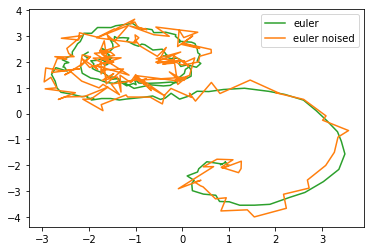

In [6]:
es = EulerScheme(dt, T, md, seed, 'numpy')
true, obs = es.noise_added_simulation(perf_initial, sys_sd, obs_sd)

plt.plot(*true.T, label='euler', color='tab:green')
plt.plot(*obs.T, label='euler noised', color='tab:orange')
plt.legend()

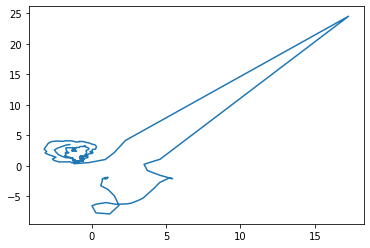

In [7]:
x_p = obs[0]
V = np.eye(2)

filtered = [x_p]
conds = []
for t in range(1, true.shape[0]):
    F = md.F(x_p, t)
    H = md.H(x_p, t)
    x_p1 = F@x_p
    V_1 = F@V@F+Q
    K = V_1@H.T@np.linalg.pinv(H@V_1@H.T + R)
    x_p = x_p1 + K@(obs[t] - H@x_p1)
    V = V_1 - K@H@V_1
    filtered.append(x_p)

filtered = np.stack(filtered)

plt.plot(*filtered.T)

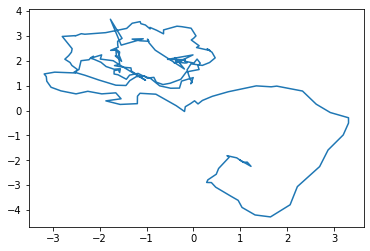

In [8]:
x_p = obs[0]
V = np.eye(2)

filtered_LOCK = [x_p]
conds = []
for t in range(update_interval, true.shape[0]):
    H = md.H(x_p, t)
    G, _, _, _ = np.linalg.lstsq(obs[t-update_interval:t-1], obs[t-update_interval+1:t], rcond=None)
    F = H@G.T@np.linalg.inv(H)
    x_p1 = F@x_p
    V_1 = F@V@F+Q
    K = V_1@H.T@np.linalg.pinv(H@V_1@H.T + R)
    x_p = x_p1 + K@(obs[t] - H@x_p1)
    V = V_1 - K@H@V_1
    filtered_LOCK.append(x_p)

filtered_LOCK = np.stack(filtered_LOCK)

plt.plot(*filtered_LOCK.T)

In [9]:
rm = np.zeros_like(obs)
N = 2
rm[:, 0] = np.convolve(obs[:, 0], np.ones(N)/N, mode='same')
rm[:, 1] = np.convolve(obs[:, 1], np.ones(N)/N, mode='same')

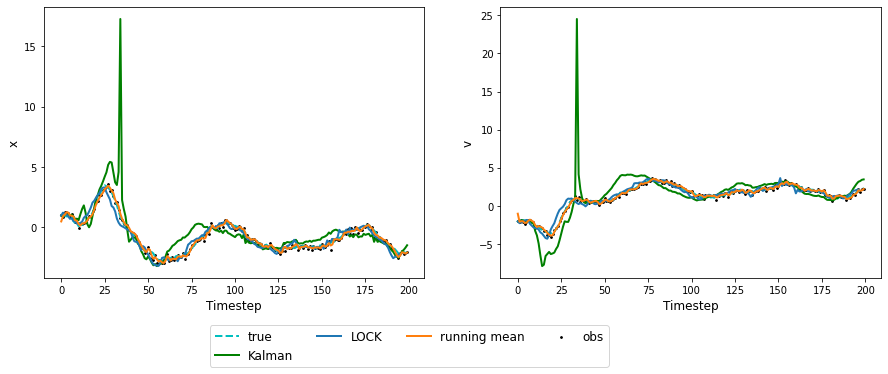

In [10]:
# plot filtered result regarding final execution
fig, axis = plt.subplots(1, 2, figsize=(15,5))
lw = 2
for i, value in enumerate(["x", "v"]):
    axis[i].plot(true[:,i], linestyle = '--', color = 'c', label = 'true', lw=lw)
    axis[i].plot(filtered[:, i], color = 'g', label =  'Kalman', lw=lw)
    axis[i].plot(filtered_LOCK[:, i], color = 'tab:blue', label =  'LOCK', lw=lw)
    axis[i].plot(rm[:,i], color = 'tab:orange', label = 'running mean', lw=lw)
    axis[i].scatter(range(T), obs[:,i], color = "k", marker = 'o', label = "obs", s=3)
    axis[i].set_xlabel('Timestep', fontsize=12)
    axis[i].set_ylabel(value, fontsize=12)
axis[0].legend(loc = 'upper right', bbox_to_anchor=(1.5, -0.15), ncol=4, fontsize=12)
fig.savefig(os.path.join(save_dir, "exnonlin1_states.png"), bbox_inches="tight")

In [11]:
print("observed MSE:", np.mean((true - obs)**2))
print("Kalman MSE:", np.mean((true - filtered)**2))
print("LOCK MSE:", np.mean((true[3:] - filtered_LOCK)**2))
print("running mean MSE:", np.mean((true - rm)**2))

observed MSE: 0.040965825684889164
Kalman MSE: 3.0862788883461216
LOCK MSE: 0.056438123546463735
running mean MSE: 0.027975799027252286
